<a href="https://colab.research.google.com/github/nisaodabas/CNG483-Project2/blob/master/CNG483_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform, RandomUniform
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model  
from keras.utils import np_utils
import matplotlib.pyplot as plt
from google.colab import output
from google.colab import drive

drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def createDataSet(path):
    df = pd.read_csv(path, sep='\n')
    data = np.array(df)

    #print(data)
    numAttr = 0
    rows = []
    for row in data:        
        found = row[0].find("@ATTRIBUTE")
        if(found != -1):
            numAttr += 1
        else:
            # ignore @ATTRIBUTE rows
            rows.append(row[0].split(","))

    # delete @DATA row
    rows = np.array(rows[1:])

    labels = rows[:, -1].astype('int')
    
    labels = np.array([x - 1 for x in labels])

    if(numAttr == 6):
        features = rows[:, :numAttr-1].astype('float')
    else:
        features = rows[:, :numAttr-1].astype('int')
        # define feature selection
        #fs = SelectKBest(score_func=f_classif, k=4000)
        # apply feature selection
        #features = fs.fit_transform(features, labels)
        

    return features, labels

In [0]:
def model(X, y, X_test, y_test, dim):
    
    # define model
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y, random_state=1)
    
    
    model = Sequential()
    model.add(Dense(36, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(36, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    #mc = ModelCheckpoint('/content/drive/My Drive/CNG483-Project 2/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    numEpochs = 5000
    batches = 96
 
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=1 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc, validation_acc, test_acc))
    

    #print(history.history.keys())
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

In [0]:
def model_textr(X, y, X_test, y_test, dim):
    
    # define model
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y, random_state=1)
    
    
    model = Sequential()
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    #mc = ModelCheckpoint('/content/drive/My Drive/CNG483-Project 2/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    numEpochs = 5000
    batches = 64
 
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=1 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc, validation_acc, test_acc))
    

    #print(history.history.keys())
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

In [0]:
def model_combined(X, y, X_test, y_test, dim):
    
    # define model
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)
    
    
    model = Sequential()
    model = Sequential()
    model.add(Dense(36, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(36, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    #mc = ModelCheckpoint('/content/drive/My Drive/CNG483-Project 2/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    numEpochs = 5000
    batches = 64
 
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=1 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc, validation_acc, test_acc))
    

    #print(history.history.keys())
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

In [0]:
if __name__ == "__main__":
    geometic_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TestingSet.txt"
    geometic_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TrainingSet.txt"

    texture_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TestingSet.txt"
    texture_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TrainingSet.txt"


    geo_x_train, geo_y_train = createDataSet(geometic_train_path)
    geo_x_test, geo_y_test = createDataSet(geometic_test_path)

    txtr_x_train, txtr_y_train = createDataSet(texture_train_path)
    txtr_x_test, txtr_y_test = createDataSet(texture_test_path)

    all_x_train = np.concatenate((txtr_x_train, geo_x_train), axis=1)
    all_x_test = np.concatenate((txtr_x_test, geo_x_test), axis=1)

Texture Features
Epoch 1/5000
17/17 [==============================] - 0s 24ms/step - loss: 1.0986 - acc: 0.3664 - val_loss: 1.0983 - val_acc: 0.4261
Epoch 2/5000
17/17 [==============================] - 0s 14ms/step - loss: 1.0978 - acc: 0.5520 - val_loss: 1.0974 - val_acc: 0.5652
Epoch 3/5000
17/17 [==============================] - 0s 13ms/step - loss: 1.0969 - acc: 0.5695 - val_loss: 1.0964 - val_acc: 0.5739
Epoch 4/5000
17/17 [==============================] - 0s 13ms/step - loss: 1.0959 - acc: 0.5734 - val_loss: 1.0953 - val_acc: 0.5739
Epoch 5/5000
17/17 [==============================] - 0s 13ms/step - loss: 1.0949 - acc: 0.5734 - val_loss: 1.0940 - val_acc: 0.5739
Epoch 6/5000
17/17 [==============================] - 0s 12ms/step - loss: 1.0935 - acc: 0.5734 - val_loss: 1.0926 - val_acc: 0.5739
Epoch 7/5000
17/17 [==============================] - 0s 13ms/step - loss: 1.0921 - acc: 0.5734 - val_loss: 1.0910 - val_acc: 0.5739
Epoch 8/5000
17/17 [==============================] 

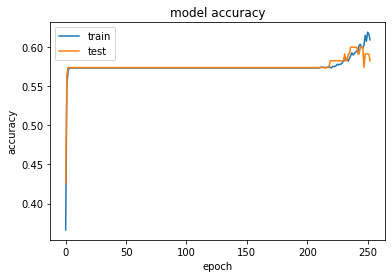

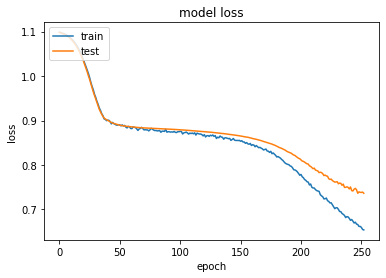

In [7]:
    print("Texture Features")
    model_textr(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, 9600)  
    

Geometric Features
Epoch 1/5000
11/11 [==============================] - 0s 14ms/step - loss: 1.2721 - acc: 0.0768 - val_loss: 1.2325 - val_acc: 0.0783
Epoch 2/5000
11/11 [==============================] - 0s 5ms/step - loss: 1.2236 - acc: 0.0865 - val_loss: 1.2055 - val_acc: 0.0783
Epoch 3/5000
11/11 [==============================] - 0s 5ms/step - loss: 1.2049 - acc: 0.0943 - val_loss: 1.1831 - val_acc: 0.0783
Epoch 4/5000
11/11 [==============================] - 0s 5ms/step - loss: 1.1814 - acc: 0.1030 - val_loss: 1.1598 - val_acc: 0.0783
Epoch 5/5000
11/11 [==============================] - 0s 5ms/step - loss: 1.1572 - acc: 0.1458 - val_loss: 1.1381 - val_acc: 0.0783
Epoch 6/5000
11/11 [==============================] - 0s 5ms/step - loss: 1.1312 - acc: 0.1992 - val_loss: 1.1144 - val_acc: 0.0783
Epoch 7/5000
11/11 [==============================] - 0s 5ms/step - loss: 1.1057 - acc: 0.3042 - val_loss: 1.0924 - val_acc: 0.5739
Epoch 8/5000
11/11 [==============================] - 0s

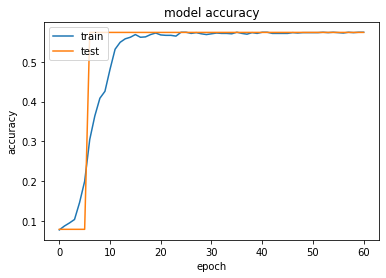

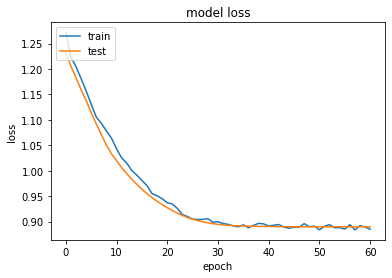

In [8]:
    print("Geometric Features")
    model(geo_x_train, geo_y_train, geo_x_test, geo_y_test, 5)
    

Both Texture and Geometric Features
Epoch 1/5000
16/16 [==============================] - 0s 16ms/step - loss: 1.0382 - acc: 0.3498 - val_loss: 1.0158 - val_acc: 0.3488
Epoch 2/5000
16/16 [==============================] - 0s 12ms/step - loss: 1.0041 - acc: 0.3498 - val_loss: 0.9896 - val_acc: 0.3488
Epoch 3/5000
16/16 [==============================] - 0s 12ms/step - loss: 0.9798 - acc: 0.3570 - val_loss: 0.9668 - val_acc: 0.3488
Epoch 4/5000
16/16 [==============================] - 0s 11ms/step - loss: 0.9594 - acc: 0.3611 - val_loss: 0.9463 - val_acc: 0.3488
Epoch 5/5000
16/16 [==============================] - 0s 11ms/step - loss: 0.9432 - acc: 0.3899 - val_loss: 0.9315 - val_acc: 0.3488
Epoch 6/5000
16/16 [==============================] - 0s 11ms/step - loss: 0.9325 - acc: 0.4300 - val_loss: 0.9181 - val_acc: 0.5756
Epoch 7/5000
16/16 [==============================] - 0s 11ms/step - loss: 0.9102 - acc: 0.5432 - val_loss: 0.9070 - val_acc: 0.5756
Epoch 8/5000
16/16 [=============

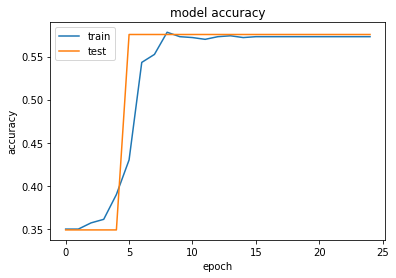

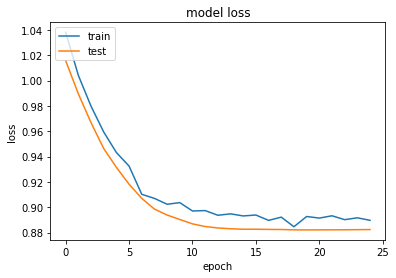

In [9]:
    print("Both Texture and Geometric Features")
    model_combined(all_x_train, txtr_y_train, all_x_test, txtr_y_test, 9605)

In [0]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')